In [45]:
import json
from collections import defaultdict, Counter
from dataclasses import dataclass, field
from pathlib import Path
from statistics import mean
from typing import Dict, Iterable, List, Optional

from complexity_map import complexity_map      #  your external dict


# --------------------------------------------------------------------------- #
# helpers
# --------------------------------------------------------------------------- #
def _read_jsonl(path: Path) -> Iterable[Dict]:
    with path.open("r", encoding="utf-8") as f:
        for line in f:
            if line := line.strip():
                yield json.loads(line)


def _ids_if(rows: Iterable[Dict], pred) -> List[int]:
    return [r["example_id"] for r in rows if pred(r)]


# --------------------------------------------------------------------------- #
# container
# --------------------------------------------------------------------------- #
@dataclass
class LLMResultMetrics:
    model_name: str
    total_queries: int

    # correctness buckets
    exact_match_ids: List[int] = field(default_factory=list)
    ast_match_ids: List[int] = field(default_factory=list)
    equiv_ids: List[int] = field(default_factory=list)        # llm_equivalent
    fulfills_intent_ids: List[int] = field(default_factory=list)
    superior_ids: List[int] = field(default_factory=list)
    incorrect_ids: List[int] = field(default_factory=list)

    # token / latency
    total_prompt_tokens: int = 0
    total_completion_tokens: int = 0
    avg_latency_sec: float = 0.0

    # prices/meta
    in_price: float = 0.0
    out_price: float = 0.0
    open_source: bool = True
    reasoning: bool = False

    # buckets – filled automatically
    per_complexity_counts: Dict[str, Counter] = field(default_factory=dict)
    per_sql_complexity_counts: Dict[str, Counter] = field(default_factory=dict)
    _complexity_id_map: Dict[str, set] = field(default_factory=dict, repr=False)
    _sqlclass_id_map:   Dict[str, set] = field(default_factory=dict, repr=False)

    # --------------------------------------------------------------------- #
    # generic accuracy helper
    # --------------------------------------------------------------------- #
    def _accuracy(self, metric: str, bucket: Optional[str] = None) -> float:
            id_pool = {
                "exact":      self.exact_match_ids,
                "ast":        self.ast_match_ids,
                "technical":  self.equiv_ids,
                "intent":     self.fulfills_intent_ids,
            }[metric]

            good_ids: set = set(id_pool)          # ← ensure *set* for “&”

            # ─────────────────────────  global  ───────────────────────── #
            if bucket is None:
                return len(good_ids) / self.total_queries if self.total_queries else 0.0

            # ─────────────────────── bucketed path ────────────────────── #
            bucket_lc = bucket.lower()
            if bucket_lc in self._complexity_id_map:          # easy / medium / hard
                denom_ids = self._complexity_id_map[bucket_lc]
            else:                                             # sql_complexity bucket
                denom_ids = self._sqlclass_id_map.get(bucket, set())

            if not denom_ids:
                return 0.0
            return len(good_ids & denom_ids) / len(denom_ids)

    # public helpers ------------------------------------------------------ #
    def accuracy_exact(self, bucket: Optional[str] = None) -> float:
        return self._accuracy("exact", bucket)

    def accuracy_ast(self, bucket: Optional[str] = None) -> float:
        return self._accuracy("ast", bucket)

    def accuracy_judge_technical(self, bucket: Optional[str] = None) -> float:
        return self._accuracy("technical", bucket)

    def accuracy_judge_intent(self, bucket: Optional[str] = None) -> float:
        return self._accuracy("intent", bucket)

    # legacy (kept for quick printing) ------------------------------------ #
    @property
    def accuracy_exact_overall(self) -> float:
        return self.accuracy_exact()
    
    # superior
    @property
    def superior(self) -> float:
        return len(self.superior_) / self.total_queries if self.total_queries else 0

    # tokens / cost ------------------------------------------------------- #
    @property
    def total_tokens(self) -> int:
        return self.total_prompt_tokens + self.total_completion_tokens

    @property
    def cost_eur(self) -> float:
        return (
            (self.total_prompt_tokens / 1_000_000) * self.in_price +
            (self.total_completion_tokens / 1_000_000) * self.out_price
        )

    # --------------------------------------------------------------------- #
    # string view
    # --------------------------------------------------------------------- #
    def __str__(self) -> str:
        return (
            f"{self.model_name}: "
            f"Exact {self.accuracy_exact():.2%} | "
            f"AST {self.accuracy_ast():.2%} | "
            f"Tech {self.accuracy_judge_technical():.2%} | "
            f"Intent {self.accuracy_judge_intent():.2%} | "
            f"Ø {self.avg_latency_sec:.2f}s | "
            f"Tokens {self.total_tokens:,} | "
            f"Cost €{self.cost_eur:.2f}"
        )

    # --------------------------------------------------------------------- #
    # factory
    # --------------------------------------------------------------------- #
    @classmethod
    def from_jsonl(
        cls,
        file: str,
        *,
        model_name="model",
        sql_complex_key="sql_complexity",
        in_price=0.0,
        out_price=0.0,
        open_source=True,
        reasoning=False,
        complexity_map: Optional[Dict[int, str]] = None,
    ):
        p = Path(file)
        rows = list(_read_jsonl(p))
        total = len(rows)

        # correctness buckets ------------------------------------------- #
        exact_ids = _ids_if(rows, lambda r: r.get("match_exact"))
        ast_ids   = _ids_if(rows, lambda r: r.get("match_ast"))
        equiv_ids = _ids_if(rows, lambda r: r.get("llm_equivalent"))
        fulfills  = _ids_if(
            rows,
            lambda r: (ej := r.get("enhanced_judgment")) and
                      ej.get("overall_assessment") in {"correct", "differently_correct"}
        )
        superior  = _ids_if(
            rows,
            lambda r: (ej := r.get("enhanced_judgment")) and
                      ej.get("superiority") in {"generated"}
        )
        incorrect = [
            r["example_id"] for r in rows
            if r["example_id"] not in (*exact_ids, *ast_ids, *equiv_ids, *fulfills)
        ]
        
        # tokens / latency --------------------------------------------- #
        prompt_tok = sum(r.get("tokens_prompt", 0) for r in rows)
        compl_tok  = sum(r.get("tokens_completion", 0) for r in rows)
        avg_lat    = mean(r.get("latency_sec", 0.0) for r in rows) if rows else 0.0

        # complexity & sql buckets ------------------------------------- #
        per_comp: Dict[str, Counter] = defaultdict(Counter)
        comp_id_map: Dict[str, set]  = defaultdict(set)

        if complexity_map:
            for r in rows:
                eid     = r["example_id"]
                bucket  = complexity_map.get(eid, "unknown").lower()
                per_comp[bucket]["total"] += 1
                comp_id_map[bucket].add(eid)
                if eid in exact_ids:
                    per_comp[bucket]["exact"] += 1

        per_sql : Dict[str, Counter] = defaultdict(Counter)
        sql_id_map: Dict[str, set]   = defaultdict(set)
        for r in rows:
            eid = r["example_id"]
            sql_cls = r.get(sql_complex_key)
            if not sql_cls:
                continue
            per_sql[sql_cls]["total"] += 1
            sql_id_map[sql_cls].add(eid)
            if eid in exact_ids:
                per_sql[sql_cls]["exact"] += 1

        # ---------------------------------------------------------------- #
        return cls(
            model_name=model_name,
            total_queries=total,
            exact_match_ids=exact_ids,
            ast_match_ids=ast_ids,
            equiv_ids=equiv_ids,
            fulfills_intent_ids=fulfills,
            superior_ids=superior,
            incorrect_ids=incorrect,
            total_prompt_tokens=prompt_tok,
            total_completion_tokens=compl_tok,
            avg_latency_sec=avg_lat,
            in_price=in_price,
            out_price=out_price,
            open_source=open_source,
            reasoning=reasoning,
            per_complexity_counts=per_comp,
            per_sql_complexity_counts=per_sql,
            _complexity_id_map=comp_id_map,
            _sqlclass_id_map=sql_id_map,
        )

# ---------------------------------------------------------------------------
# create one metrics object per file
# ---------------------------------------------------------------------------
BENCH_DIR           = Path("better_benchmarks")
_SUFFIX             = ".jsonl"                 # all files end with this
metrics: Dict[str, LLMResultMetrics] = {}

for json_file in sorted(BENCH_DIR.glob(f"*{_SUFFIX}")):
    model_name  = json_file.stem                         # e.g. deepseek-r1-14b
    var_name    = model_name.replace("-", "_")           # python-valid identifier
    m           = LLMResultMetrics.from_jsonl(
        json_file,
        model_name=model_name,
        complexity_map=complexity_map,
    )
    metrics[var_name] = m
    globals()[var_name] = m     # optional: create variable in global scope

metrics["gpt_4.1"].open_source=False
metrics["gpt_4.1_mini"].open_source=False
metrics["gpt_4.1_nano"].open_source=False
metrics["o3"].open_source=False
metrics["o3"].reasoning=True
metrics["o3_mini"].open_source=False
metrics["o3_mini"].reasoning=True
metrics["o4_mini"].open_source=False
metrics["o4_mini"].reasoning=True

In [ ]:
# ---------------------------------------------------------------------------
# config
# ---------------------------------------------------------------------------
_LEETCODE_CLASSES   = [
    "basic SQL", "aggregation", "single join", "window functions",
    "multiple_joins", "subqueries", "set operations"
]                                              # adjust if needed
_COMPLEXITY_CLASSES = ["easy", "medium", "hard"]

# ---------------------------------------------------------------------------
# helper to print bucketed accuracies for one model
# ---------------------------------------------------------------------------
def print_bucket_report(model_key: str) -> None:
    m = metrics[model_key]
    print(f"\n=== {model_key} ===")
    for lc in _LEETCODE_CLASSES:
        print(f"{lc:<18} : {m.accuracy_judge_technical(lc)*100:4.1f}%")
    for cc in _COMPLEXITY_CLASSES:
        print(f"{cc:<18} : {m.accuracy_judge_technical(cc)*100:4.1f}%")

# ---------------------------------------------------------------------------
# example: show report for every model
# ---------------------------------------------------------------------------
for key in metrics:
    print_bucket_report(key)


=== deepseek_r1_14b ===
basic SQL          : 60.7%
aggregation        : 64.3%
single join        : 28.6%
window functions   : 14.3%
multiple_joins     : 21.4%
subqueries         : 21.4%
set operations     : 21.4%
easy               : 64.2%
medium             : 23.3%
hard               :  0.0%

=== gemma3_12b ===
basic SQL          : 60.7%
aggregation        : 60.7%
single join        : 50.0%
window functions   : 14.3%
multiple_joins     : 28.6%
subqueries         : 25.0%
set operations     : 17.9%
easy               : 62.3%
medium             : 29.3%
hard               :  0.0%

=== gpt_4.1_mini ===
basic SQL          : 64.3%
aggregation        : 64.3%
single join        : 35.7%
window functions   : 10.7%
multiple_joins     : 35.7%
subqueries         : 21.4%
set operations     : 28.6%
easy               : 66.0%
medium             : 28.6%
hard               :  0.0%

=== gpt_4.1_nano ===
basic SQL          : 60.7%
aggregation        : 64.3%
single join        : 39.3%
window functions   :

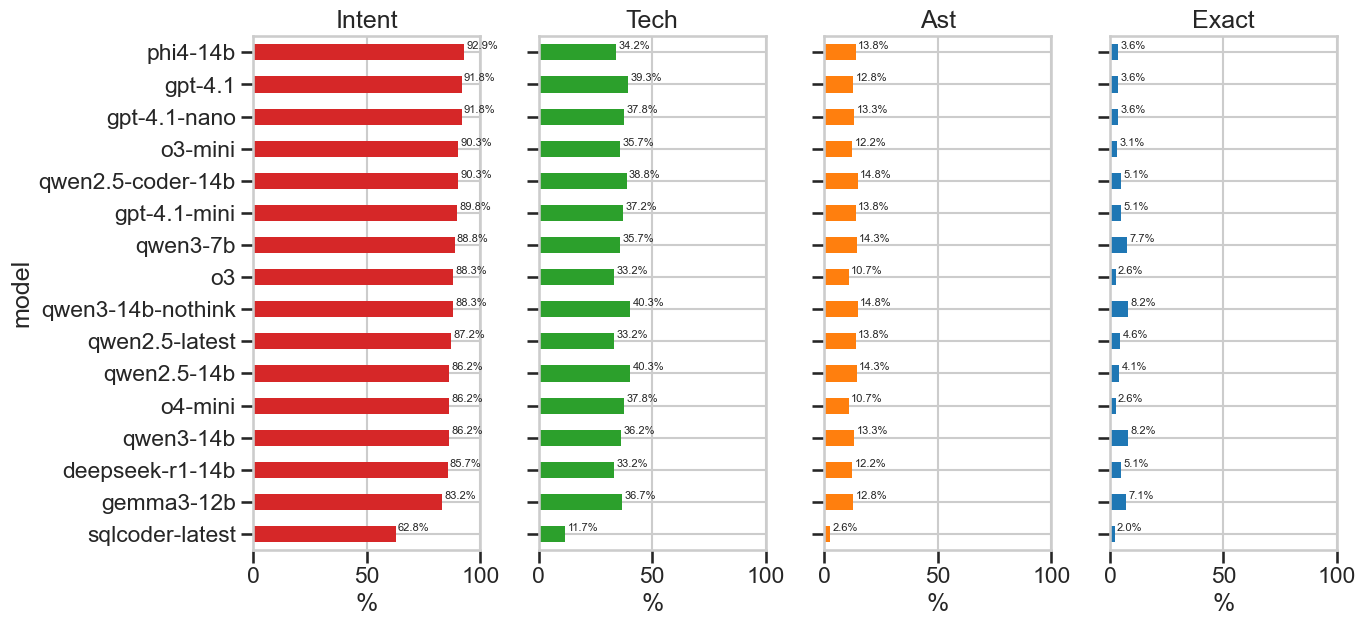

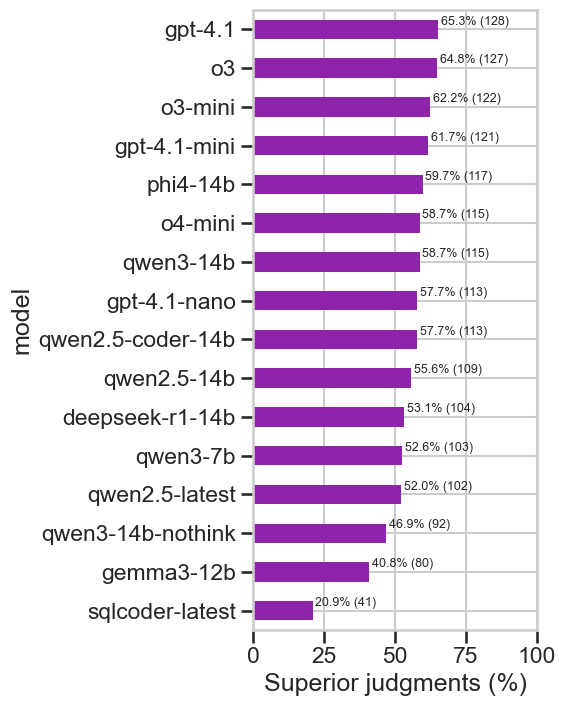

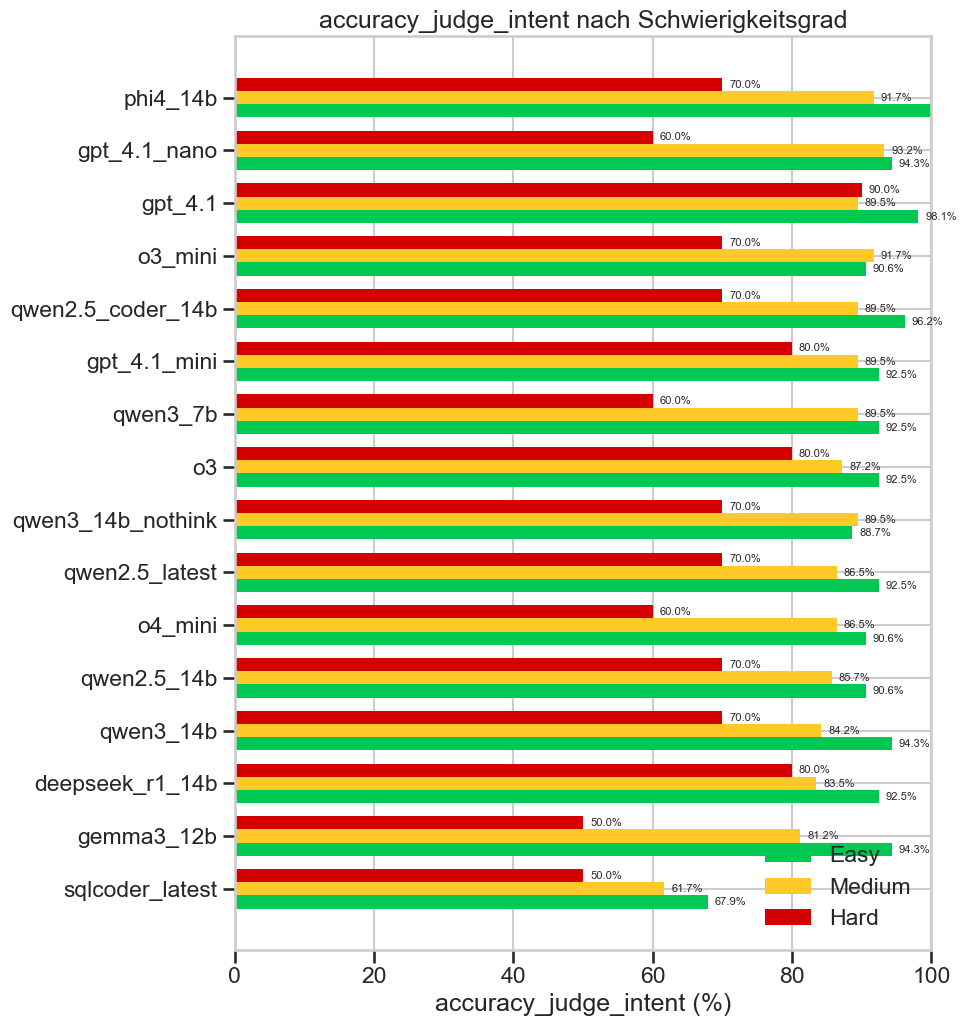

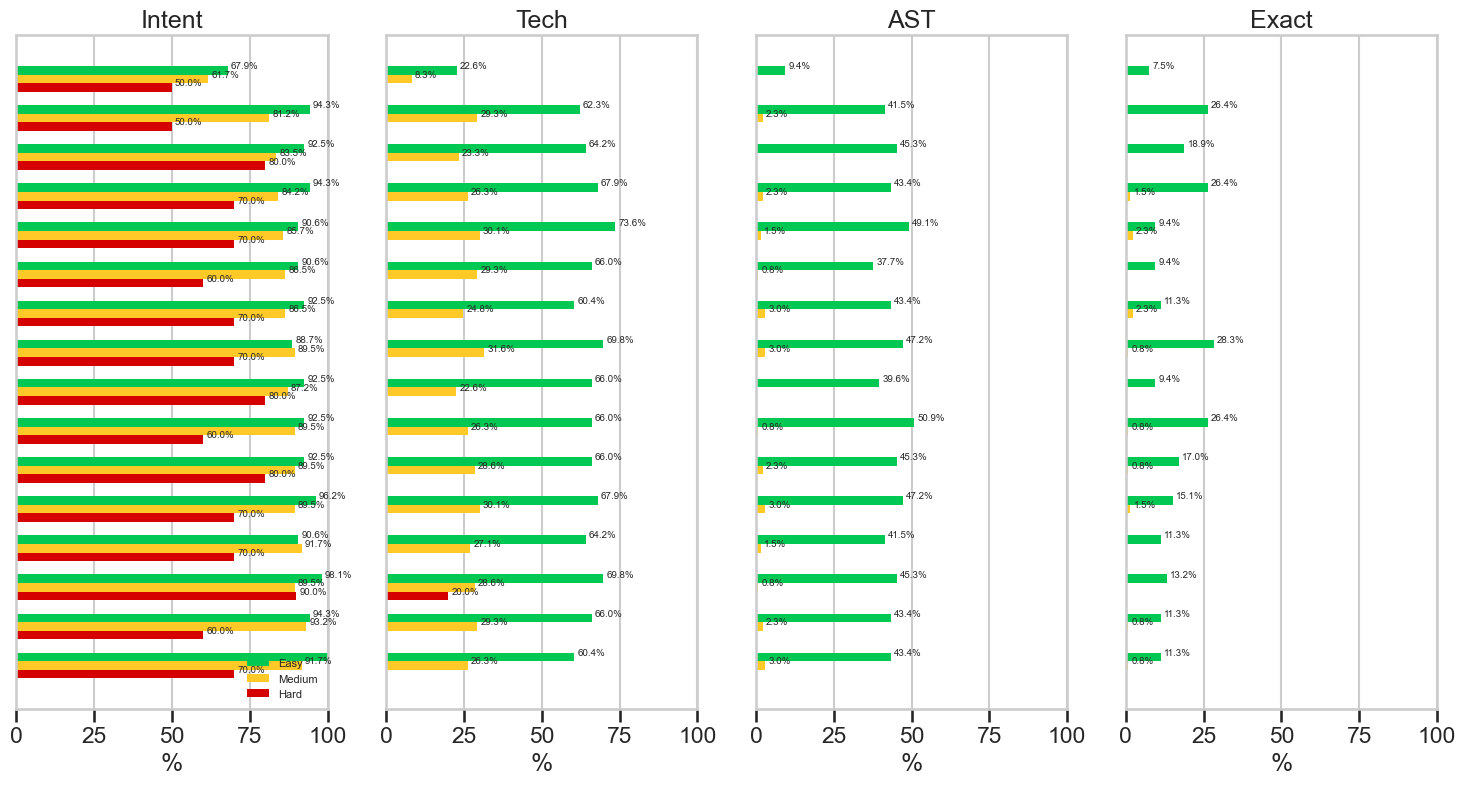

In [47]:
# viz_toolbox.py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from typing import Dict, List

# ──────────────────────────────────────────────────────────────────────────
# Helper – turn the metrics-dict (var_name → LLMResultMetrics) into nice DF
# ──────────────────────────────────────────────────────────────────────────
_LEETCODE_CLASSES = [
    "basic SQL", "aggregation", "single join",
    "window functions", "multiple_joins", "subqueries", "set operations"
]
_COMPLEXITY_CLASSES = ["easy", "medium", "hard"]


def _build_df(metrics: Dict[str, "LLMResultMetrics"]) -> pd.DataFrame:
    rows = []
    for name, m in metrics.items():
        rows.append(
            dict(
                model=name,
                total=m.total_queries,
                exact=m.accuracy_exact(),
                ast=m.accuracy_ast(),
                tech=m.accuracy_judge_technical(),
                intent=m.accuracy_judge_intent(),
                superior_cnt=len(m.superior_ids),
                cost=m.cost_eur,
                latency=m.avg_latency_sec,
                **{f"diff_{c}": m.accuracy_exact(c) for c in _COMPLEXITY_CLASSES},
                **{lc: m.accuracy_exact(lc) for lc in _LEETCODE_CLASSES},
            )
        )
    return pd.DataFrame(rows).set_index("model")


# ──────────────────────────────────────────────────────────────────────────
# 1. Overall accuracy bar-chart
# ──────────────────────────────────────────────────────────────────────────
def plot_overall(df: pd.DataFrame, metric: str = "intent") -> None:
    """
    metric ∈ {exact, ast, tech, intent}
    """
    ax = (df[metric] * 100).sort_values(ascending=False).plot.barh(
        figsize=(6, 0.4 * len(df) + 1),
        color="steelblue",
    )
    ax.set_xlabel(f"{metric} accuracy (%)")
    ax.set_ylabel("model")
    ax.set_xlim(0, 100)
    for p in ax.patches:
        ax.annotate(f"{p.get_width():.1f}%", (p.get_width() + 1, p.get_y() + 0.1))
    plt.gca().invert_yaxis()
    plt.tight_layout()

_CMAP = {
    "exact":      "#1f77b4",   # blue
    "ast":        "#ff7f0e",   # orange
    "tech":       "#2ca02c",   # green
    "intent":     "#d62728",   # red
}

def plot_overall_multi(df: pd.DataFrame) -> None:
    """
    Four horizontally aligned bar-plots (Exact / AST / Tech / Intent).
    Model order is defined by descending *Intent* accuracy.
    """
    metrics = ["intent", "tech", "ast", "exact"]

    # ── ordering of rows by intent accuracy ────────────────────────────
    order = df["intent"].sort_values(ascending=False).index
    df_sorted = df.loc[order]

    # ── build the 4-subplot canvas ─────────────────────────────────────
    n_models = len(df_sorted)
    fig, axes = plt.subplots(
        nrows=1, ncols=4,
        figsize=(14, 0.35 * n_models + 1),
        sharey=True
    )

    for ax, metric in zip(axes, metrics):
        (df_sorted[metric] * 100).plot.barh(
            ax=ax,
            color=_CMAP[metric],
        )
        ax.set_title(metric.capitalize())
        ax.set_xlim(0, 100)
        ax.set_xlabel("%")
        ax.set_ylabel("")           # shared y-axis; no duplicate label
        ax.invert_yaxis()           # highest value on top
        for p in ax.patches:
            ax.annotate(
                f"{p.get_width():.1f}%",
                (p.get_width() + 1, p.get_y() + 0.15),
                fontsize=8,
            )

    axes[0].set_ylabel("model")     # only leftmost subplot shows label
    plt.tight_layout()

# ---------------------------------------------------------------------------
# metrics_dict  :  {"deepseek_r1_14b": LLMResultMetrics, ...}
# metric_fn_name:  "accuracy_exact" | "accuracy_ast" | "accuracy_judge_technical"
# ---------------------------------------------------------------------------
def plot_difficulty_grouped(
    metrics_dict: Dict[str, "LLMResultMetrics"],
    metric_fn_name: str = "accuracy_judge_technical",
) -> None:
    """
    Drei horizontale Balken (easy / medium / hard) pro Modell,
    sortiert absteigend nach der *globalen* Accuracy des gewünschten Metrics.
    """

    # 1) Daten sammeln ----------------------------------------------------
    rows = []
    for name, m in metrics_dict.items():
        fn = getattr(m, metric_fn_name)          # gewünschte Accuracy-Methode
        rows.append(
            dict(
                model=name,
                total=fn(),                      # globale Accuracy
                easy=fn("easy"),
                medium=fn("medium"),
                hard=fn("hard"),
            )
        )

    # in DataFrame oder Liste überführen
    rows.sort(key=lambda r: r["total"], reverse=True)   # sortieren nach total

    # 2) Plot vorbereiten --------------------------------------------------
    y_pos  = np.arange(len(rows))          # 0,1,2,…
    bar_h  = 0.25                          # Höhe je Balken

    plt.figure(figsize=(10, 0.6 * len(rows) + 1))

    # 3 Balken je Modell
    plt.barh(y_pos + bar_h, [r["easy"]*100  for r in rows],
             height=bar_h, color="#00c853", label="Easy")
    plt.barh(y_pos,          [r["medium"]*100 for r in rows],
             height=bar_h, color="#ffca28", label="Medium")
    plt.barh(y_pos - bar_h, [r["hard"]*100  for r in rows],
             height=bar_h, color="#d50000", label="Hard")

    # Achsen & Beschriftungen
    plt.yticks(y_pos, [r["model"] for r in rows])
    plt.xlim(0, 100)
    plt.xlabel(f"{metric_fn_name} (%)")
    plt.title(f"{metric_fn_name} nach Schwierigkeitsgrad")
    plt.legend(loc="lower right")

    # Balken beschriften
    for offset, key in [(bar_h, "easy"), (0, "medium"), (-bar_h, "hard")]:
        for y, r in zip(y_pos, rows):
            val = r[key] * 100
            plt.annotate(f"{val:.1f}%",
                         (val + 1, y + offset + bar_h / 4),
                         fontsize=8)

    plt.gca().invert_yaxis()
    plt.tight_layout()

import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List

# Farbpalette
_EASY_COL, _MED_COL, _HARD_COL = "#00c853", "#ffca28", "#d50000"
_METRIC_ORDER: List[str] = [
    "accuracy_judge_intent",
    "accuracy_judge_technical",
    "accuracy_ast",
    "accuracy_exact",
]
_METRIC_TITLES = {
    "accuracy_judge_intent":      "Intent",
    "accuracy_judge_technical":   "Tech",
    "accuracy_ast":               "AST",
    "accuracy_exact":             "Exact",
}


def plot_difficulty_multi_metrics(metrics_dict: Dict[str, "LLMResultMetrics"]) -> None:
    """
    Vier Subplots (Intent / Tech / AST / Exact).
    Jeder Subplot: drei Balken (Easy / Medium / Hard) pro Modell.
    Modelle sind nach Intent-Accuracy (gesamt) absteigend sortiert.
    """

    # ------------------------------------------------------------------ #
    # 1) Daten einsammeln
    # ------------------------------------------------------------------ #
    rows = {}
    for name, m in metrics_dict.items():
        rows[name] = {
            "intent":     m.accuracy_judge_intent(),
            "tech":       m.accuracy_judge_technical(),
            "ast":        m.accuracy_ast(),
            "exact":      m.accuracy_exact(),
            "easy": {
                fn: getattr(m, fn)("easy") for fn in _METRIC_ORDER
            },
            "medium": {
                fn: getattr(m, fn)("medium") for fn in _METRIC_ORDER
            },
            "hard": {
                fn: getattr(m, fn)("hard") for fn in _METRIC_ORDER
            },
        }

    # Sortieren nach Intent-Accuracy
    model_order = sorted(rows.keys(), key=lambda k: rows[k]["intent"], reverse=True)
    n_models = len(model_order)
    y_pos = np.arange(n_models)
    bar_h = 0.22

    # ------------------------------------------------------------------ #
    # 2) Plot-Canvas
    # ------------------------------------------------------------------ #
    fig, axes = plt.subplots(
        nrows=1, ncols=4,
        figsize=(15, 0.45 * n_models + 1),
        sharey=True
    )

    for ax, metric_fn in zip(axes, _METRIC_ORDER):
        # Easy / Medium / Hard Werte je Modell
        easy   = [rows[m]["easy"][metric_fn]   * 100 for m in model_order]
        medium = [rows[m]["medium"][metric_fn] * 100 for m in model_order]
        hard   = [rows[m]["hard"][metric_fn]   * 100 for m in model_order]

        # Drei Balken je Modell
        ax.barh(y_pos + bar_h, easy,   bar_h, color=_EASY_COL, label="Easy")
        ax.barh(y_pos,          medium, bar_h, color=_MED_COL,  label="Medium")
        ax.barh(y_pos - bar_h, hard,   bar_h, color=_HARD_COL,  label="Hard")

        ax.set_title(_METRIC_TITLES[metric_fn])
        ax.set_xlim(0, 100)
        ax.set_xlabel("%")
        ax.invert_yaxis()

        # Balkenbeschriftungen
        for idx, (e, m_, h) in enumerate(zip(easy, medium, hard)):
            for val, off in [(e, bar_h), (m_, 0), (h, -bar_h)]:
                if val > 0:
                    ax.annotate(f"{val:.1f}%",
                                (val + 1, idx + off + bar_h / 4),
                                fontsize=7)

        # y-Ticks nur links
        if ax is axes[0]:
            ax.set_yticks(y_pos)
            ax.set_yticklabels(model_order)
            ax.legend(loc="lower right", fontsize=8)
        else:
            ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# ──────────────────────────────────────────────────────────────────────────
# 2. Easy / Medium / Hard stacked bars
# ──────────────────────────────────────────────────────────────────────────
def plot_difficulty_split(df: pd.DataFrame) -> None:
    diff_df = df[[f"diff_{c}" for c in _COMPLEXITY_CLASSES]] * 100
    diff_df.columns = _COMPLEXITY_CLASSES
    diff_df.sort_index(inplace=True)

    diff_df.plot(kind="barh",
                 stacked=True,
                 color=["#00c853", "#ffca28", "#d50000"],
                 figsize=(6, 0.4 * len(diff_df) + 1))
    plt.legend(loc="lower right", bbox_to_anchor=(1.25, 0))
    plt.xlabel("Exact accuracy per difficulty (%)")
    plt.xlim(0, 100)
    plt.tight_layout()


# ──────────────────────────────────────────────────────────────────────────
# 3. SQL-class heat-map
# ──────────────────────────────────────────────────────────────────────────
def plot_sql_heatmap(df: pd.DataFrame) -> None:
    sql_df = df[_LEETCODE_CLASSES] * 100
    plt.figure(figsize=(10, 0.5 * len(df) + 1))
    sns.heatmap(sql_df,
                annot=True,
                fmt=".1f",
                cmap="Blues",
                linewidths=0.5,
                cbar_kws={"label": "Exact accuracy (%)"})
    plt.xlabel("")
    plt.ylabel("model")
    plt.tight_layout()

# -----------------------------------------------------------------------
#   visual: plot number of *superior* decisions per model
# -----------------------------------------------------------------------
def plot_superior(df: pd.DataFrame, *, show_counts: bool = True) -> None:
    """
    Horizontal bar-chart showing *percentage* of superior judgments.
    Data-frame must contain columns  `total`  and  `superior_cnt`.
    """
    pct = (df["superior_cnt"] / df["total"] * 100).sort_values(ascending=False)

    ax = pct.plot.barh(
        figsize=(6, 0.4 * len(pct) + 1),
        color="#8e24aa",
    )
    ax.set_xlabel("Superior judgments (%)")
    ax.set_ylabel("model")
    ax.set_xlim(0, 100)
    ax.invert_yaxis()               # best model on top

    # annotate each bar --------------------------------------------------
    for bar, (model, pct_val) in zip(ax.patches, pct.items()):
        raw = int(df.loc[model, "superior_cnt"])
        txt = f"{pct_val:.1f}%"
        if show_counts:
            txt += f" ({raw})"
        ax.annotate(
            txt,
            (bar.get_width() + 1, bar.get_y() + bar.get_height() / 4),
            fontsize=9,
        )

    plt.tight_layout()

# ──────────────────────────────────────────────────────────────────────────
# 4. “Bang-for-buck” scatter: cost vs. overall intent accuracy
# ──────────────────────────────────────────────────────────────────────────
def plot_cost_vs_accuracy(df: pd.DataFrame) -> None:
    ax = sns.scatterplot(
        data=df,
        x="cost",
        y=df["intent"] * 100,
        s=120,
    )
    for txt, row in df.iterrows():
        ax.annotate(txt, (row["cost"], row["intent"] * 100),
                    textcoords="offset points", xytext=(0, 5), ha="center")
    ax.set_xlabel("Total evaluation cost (€)")
    ax.set_ylabel("Intent accuracy (%)")
    ax.set_title("Bang-for-buck")
    plt.tight_layout()


# ──────────────────────────────────────────────────────────────────────────
# 5. Radar plot for a single model
# ──────────────────────────────────────────────────────────────────────────
def plot_radar(model_name: str, metrics_df: pd.DataFrame) -> None:
    row = metrics_df.loc[model_name, _LEETCODE_CLASSES] * 100
    # ─ matplotlib radar boiler-plate ─
    labels = row.index.to_list()
    values = row.to_list()
    values += values[:1]                      # close polygon
    angles = [n / float(len(labels)) * 2 * 3.14159 for n in range(len(labels))]
    angles += angles[:1]

    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    ax.plot(angles, values, marker="o", color="teal")
    ax.fill(angles, values, alpha=0.25, color="teal")
    ax.set_thetagrids([a * 180/3.14159 for a in angles[:-1]], labels)
    ax.set_ylim(0, 100)
    ax.set_title(model_name)
    plt.tight_layout()


# ──────────────────────────────────────────────────────────────────────────
# Example usage  (put this at bottom of your notebook / script)
# ──────────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    from pathlib import Path
    from complexity_map import complexity_map

    BENCH_DIR = Path("better_benchmarks")

    metrics_objects = {}
    for f in BENCH_DIR.glob("*.jsonl"):
        metrics_objects[f.stem] = LLMResultMetrics.from_jsonl(
            f,
            model_name=f.stem,
            complexity_map=complexity_map,
        )

    df = _build_df(metrics_objects)

    # Pick and choose the visual you want:
    plot_overall_multi(df)
    plt.show()

    plot_superior(df)
    plt.show()

    plot_difficulty_grouped(metrics, metric_fn_name="accuracy_judge_intent")
    plt.show()

    plot_difficulty_multi_metrics(metrics)
    plt.show()

    # plot_difficulty_split(df)
    # plt.show()

    # plot_sql_heatmap(df)
    # plt.show()

    # plot_cost_vs_accuracy(df)
    # plt.show()

    # plot_radar("gpt-4.1", df)      # put any model-name you have
    # plt.show()

In [79]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from adjustText import adjust_text

def create_model_comparison_chart(
    metrics_dict, 
    accuracy_metric='intent',
    save_path=None,
    custom_title=None
):
    """
    Create a scatter plot comparing models by accuracy, latency, and token usage.
    Dynamically adjusts visualization parameters based on the chosen accuracy metric.
    """
    # Set style for a cleaner look
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("talk")

    # Map accuracy metric to method
    accuracy_method = {
        'exact': 'accuracy_exact',
        'ast': 'accuracy_ast',
        'technical': 'accuracy_judge_technical',
        'intent': 'accuracy_judge_intent'
    }.get(accuracy_metric.lower(), 'accuracy_judge_intent')
    
    # Create DataFrame from metrics
    model_data = []
    for model_key, m in metrics_dict.items():
        accuracy_func = getattr(m, accuracy_method)
        model_data.append({
            'model': m.model_name,
            'accuracy': accuracy_func() * 100,  # Convert to percentage
            'avg_time': m.avg_latency_sec,
            'avg_tokens': m.total_completion_tokens / m.total_queries if m.total_queries > 0 else 0,
            'total_examples': m.total_queries,
            'open_source': m.open_source
        })

    acc_df = pd.DataFrame(model_data)
    
    # Print data for debugging
    # print("Generated data for plotting:")
    # print(acc_df[['model', 'accuracy', 'avg_time', 'avg_tokens']])
    
    # Determine metric-specific parameters
    metric_configs = {
        'exact': {
            'threshold': 10,  # Lower threshold for exact match
            'zone_text': 'Efficient & Accurate Zone\n(>80% Exact Match, <6s Latency)',
            'min_y_limit': 0,  # Start from 0 for exact match
            'color_scheme': 'Blues'
        },
        'ast': {
            'threshold': 16,  # Threshold for AST match
            'zone_text': 'Efficient & Accurate Zone\n(>85% AST Match, <6s Latency)',
            'min_y_limit': 0,
            'color_scheme': 'Greens'
        },
        'technical': {
            'threshold': 45,
            'zone_text': 'Efficient & Accurate Zone\n(>85% Technical Accuracy, <6s Latency)',
            'min_y_limit': 0,
            'color_scheme': 'Purples'
        },
        'intent': {
            'threshold': 101,  # Higher threshold for intent fulfillment
            'zone_text': 'Efficient & Accurate Zone\n(>90% Intent Fulfillment, <6s Latency)',
            'min_y_limit': 0,
            'color_scheme': 'Oranges'
        }
    }
    
    config = metric_configs.get(accuracy_metric.lower(), metric_configs['intent'])
    threshold = config['threshold']
    # zone_text = config['zone_text']
    min_y_limit = config['min_y_limit']
    
    # Define model categories and colors
    acc_df['category'] = acc_df['open_source'].apply(
        lambda x: 'Open Source Models' if x else 'Closed Source Models')
    category_colors = {
        'Open Source Models': '#009E73',  # Teal green
        'Closed Source Models': '#0072B2'  # Blue
    }
    acc_df['color'] = acc_df['category'].map(category_colors).fillna('#999999')
    
    # Scale token counts for bubble sizes
    S_MIN, S_MAX = 100, 2000
    def scale_sizes(series, s_min=S_MIN, s_max=S_MAX):
        if len(series) <= 1 or series.max() == series.min():
            return np.full_like(series, (s_min + s_max) / 2)
        return np.interp(series, (series.min(), series.max()), (s_min, s_max))
        
    sizes = scale_sizes(acc_df["avg_tokens"])

    # Create plot with log scale
    fig, ax = plt.subplots(figsize=(18, 14))
    ax.set_xscale('log')
    ax.grid(which='major', linestyle='--', alpha=0.7, zorder=0)
    ax.grid(which='minor', linestyle=':', alpha=0.4, zorder=0)
    
    # # Add "efficient & accurate" zone with metric-specific threshold
    # threshold_ratio = 1 - ((100 - threshold) / (100 - min_y_limit)) if min_y_limit < 100 else 0.2
    # ax.axvspan(0, 6, ymin=threshold_ratio, facecolor='green', alpha=0.1, zorder=1)
    # ax.text(2.5, threshold + 2, zone_text,
    #         fontsize=14, color='darkgreen', style='italic', weight='bold')
    
    # Create scatter plot
    scatter = ax.scatter(
        acc_df["avg_time"], acc_df["accuracy"], s=sizes, c=acc_df["color"],
        alpha=0.8, edgecolors='black', linewidth=1.2, zorder=10
    )

    # Add model labels directly next to their points
    texts = []
    for i, row in acc_df.iterrows():
        # Offset text slightly from the point for visibility
        text = ax.text(
            row.avg_time * 1.05, row.accuracy, row.model,
            fontsize=11,
            fontweight='bold', zorder=25,
            color='black',
            bbox=dict(facecolor='white', edgecolor='black', alpha=0.7, pad=1.5, boxstyle='round,pad=0.5')
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='white', alpha=0.8),
            path_effects.Normal()
        ])
        texts.append(text)

    # Use adjust_text with more conservative settings that won't push labels far away
    if len(texts) > 1:
        try:
            adjust_text(texts, ax=ax,
                       force_text=(10.5, 10.5),         # Reduced force
                       force_points=(10.2, 10.2),       # Reduced force from points
                       expand_text=(1.1, 1.1),        # Less expansion
                       expand_points=(1.05, 1.05),    # Less expansion
                       arrowprops=dict(arrowstyle='-', color='gray', lw=0.5),  # Add connecting lines
                       autoalign=False,               # Don't auto-align
                       lim=20)                        # Fewer iterations
        except Exception as e:
            print(f"adjust_text error: {e}. Continuing without adjusting text.")

    # Add legend for model categories
    category_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                            markeredgecolor='black', markersize=15, label=category) 
                        for category, color in category_colors.items()]
    type_legend = ax.legend(handles=category_handles, loc="upper right", fontsize=14, 
                            frameon=True, framealpha=0.95, title="Legend", title_fontsize=16)
    ax.add_artist(type_legend)

    # Create token size legend
    if len(acc_df) > 1:
        token_vals = [int(acc_df["avg_tokens"].min()), 
                    int(acc_df["avg_tokens"].median()), 
                    int(acc_df["avg_tokens"].max())]
        size_vals = scale_sizes(pd.Series(token_vals))
        handles = [plt.scatter([], [], s=s, color="gray", edgecolor="black", linewidth=1.0) 
                  for s in size_vals]
        labels = [f"{t:,} tokens" for t in token_vals]
        size_legend = ax.legend(handles, labels, title="Avg Completion Tokens", 
                              loc="lower right", fontsize=14, title_fontsize=16, 
                              labelspacing=2.2, borderpad=1.2, handletextpad=1.5, 
                              frameon=True, framealpha=0.95)
        ax.add_artist(size_legend)

    # Set labels and title
    ax.set_xlabel("Average Query Time (seconds, log scale) →", fontsize=16, fontweight='bold')
    ax.set_ylabel("↑ Accuracy (%)", fontsize=16, fontweight='bold')
    
    metric_display_names = {
        'exact': 'Exact Match', 
        'ast': 'AST Match', 
        'technical': 'Technical Accuracy', 
        'intent': 'Intent Fulfillment'
    }
    metric_display = metric_display_names.get(accuracy_metric.lower(), accuracy_metric.title())
    
    if custom_title:
        ax.set_title(custom_title, fontsize=20, fontweight='bold', pad=25)
    else:
        ax.set_title(f"SQL Model Performance: {metric_display} vs. Latency", 
                    fontsize=20, fontweight='bold', pad=25)

    # Configure axis ticks and limits
    major_ticks = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40]
    ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())

    # Dynamically set y-axis
    if not acc_df.empty:
        data_min = max(0, acc_df["accuracy"].min() - 5)
        data_max = min(100, acc_df["accuracy"].max() + 5)
        y_min = max(min_y_limit, data_min)
        if data_max - y_min < 20:  # Ensure a reasonable range
            y_min = max(0, data_max - 20)
        ax.set_ylim(y_min, data_max)
    else:
        ax.set_ylim(min_y_limit, 100)
        
    ax.set_xlim(left=0.8, right=acc_df["avg_time"].max() * 1.2 if not acc_df.empty else 40)

    # Add metric-specific notes
    note_texts = {
        'exact': "Note: Accuracy based on exact string match.",
        'ast': "Note: Accuracy based on Abstract Syntax Tree matching.",
        'technical': "Note: Accuracy based on technical equivalence assessment.",
        'intent': "Note: Accuracy based on intent fulfillment assessment."
    }
    note_text = note_texts.get(accuracy_metric.lower(), f"Note: Accuracy based on '{accuracy_metric}' assessment.")
    plt.figtext(0.5, 0.01, note_text, ha='center', fontsize=12, style='italic')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

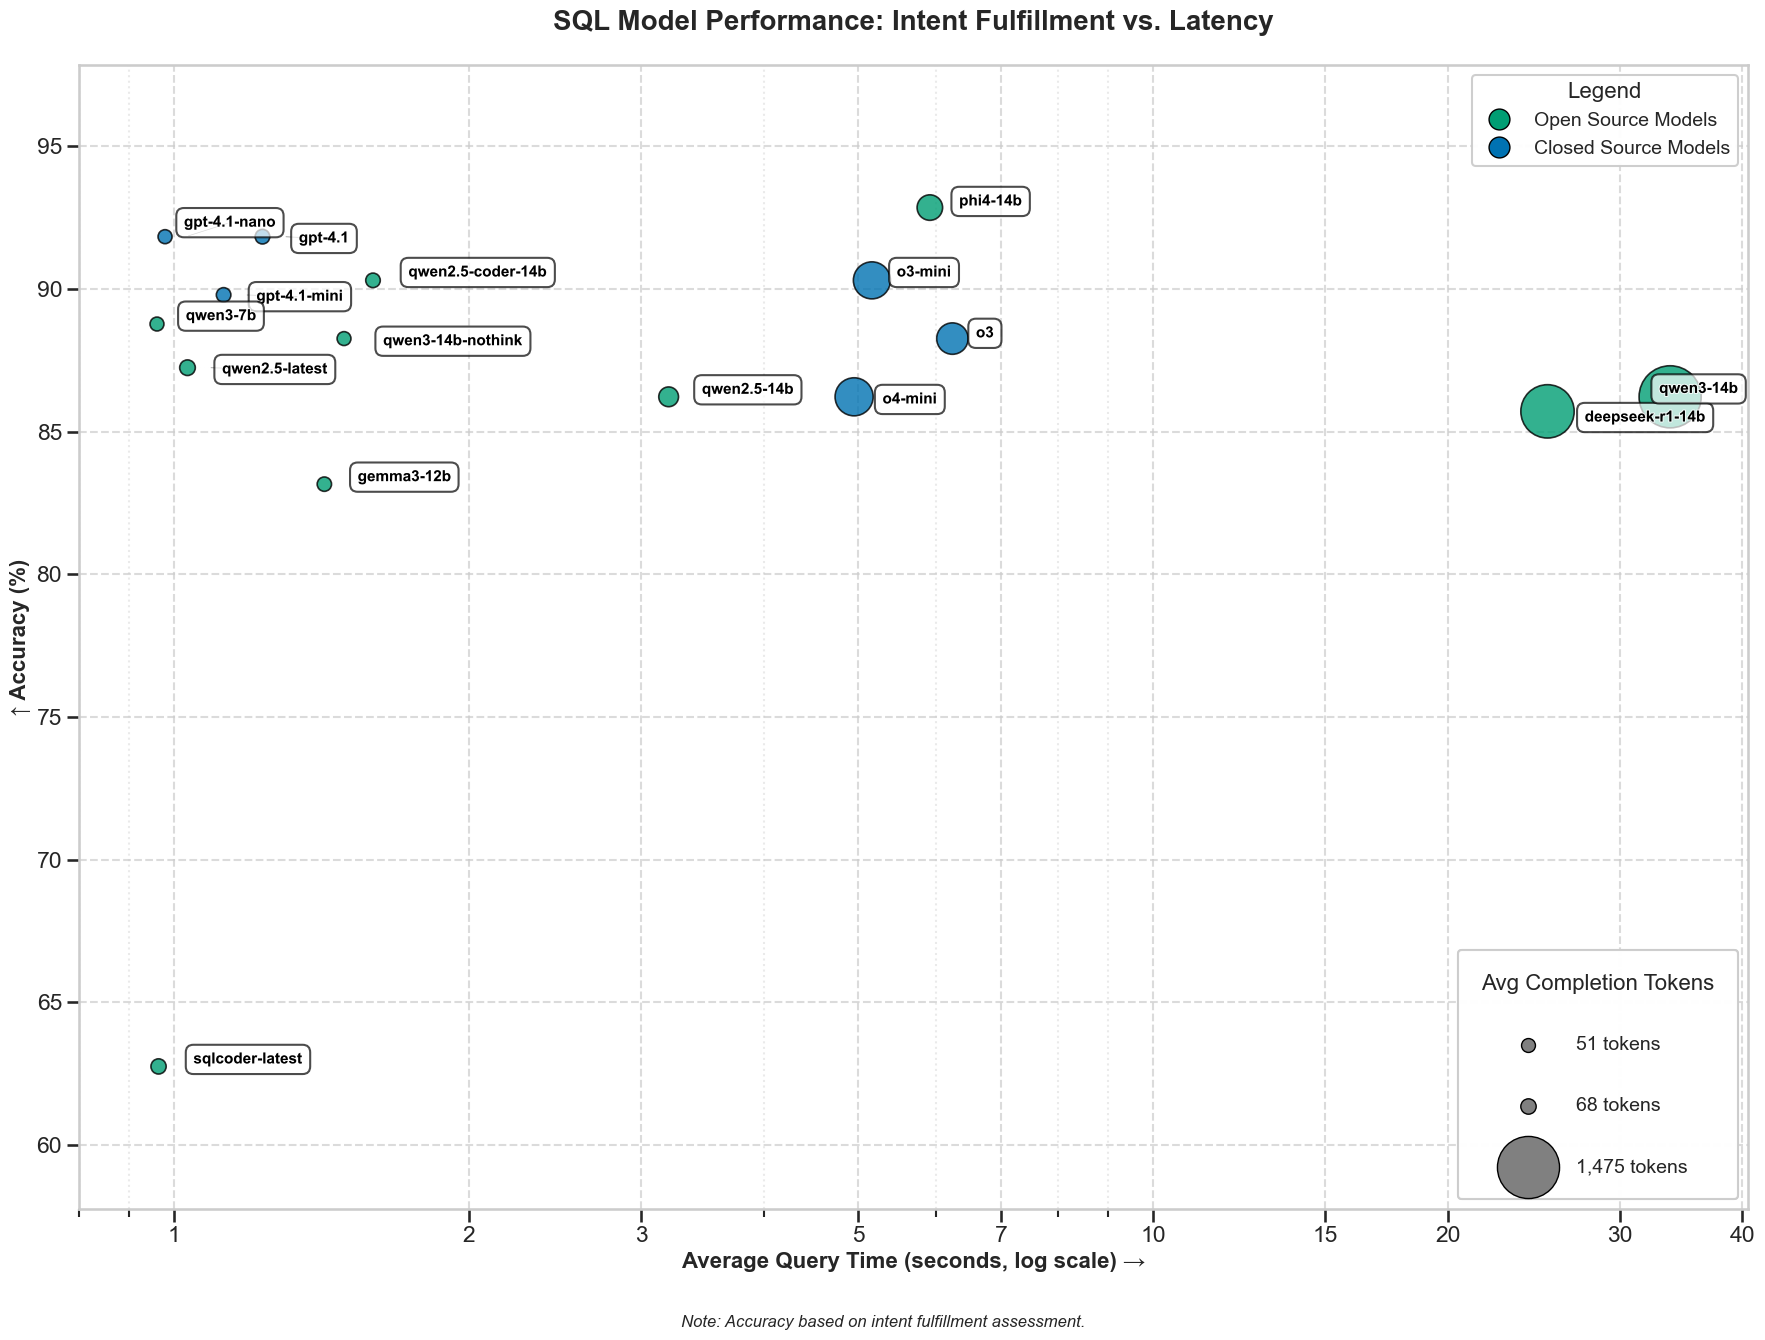

In [80]:
create_model_comparison_chart(metrics, accuracy_metric='intent')
plt.show()

(<Figure size 1800x1400 with 1 Axes>,
 <Axes: title={'center': 'SQL Model Performance: Exact Match vs. Latency'}, xlabel='Average Query Time (seconds, log scale) →', ylabel='↑ Accuracy (%)'>)

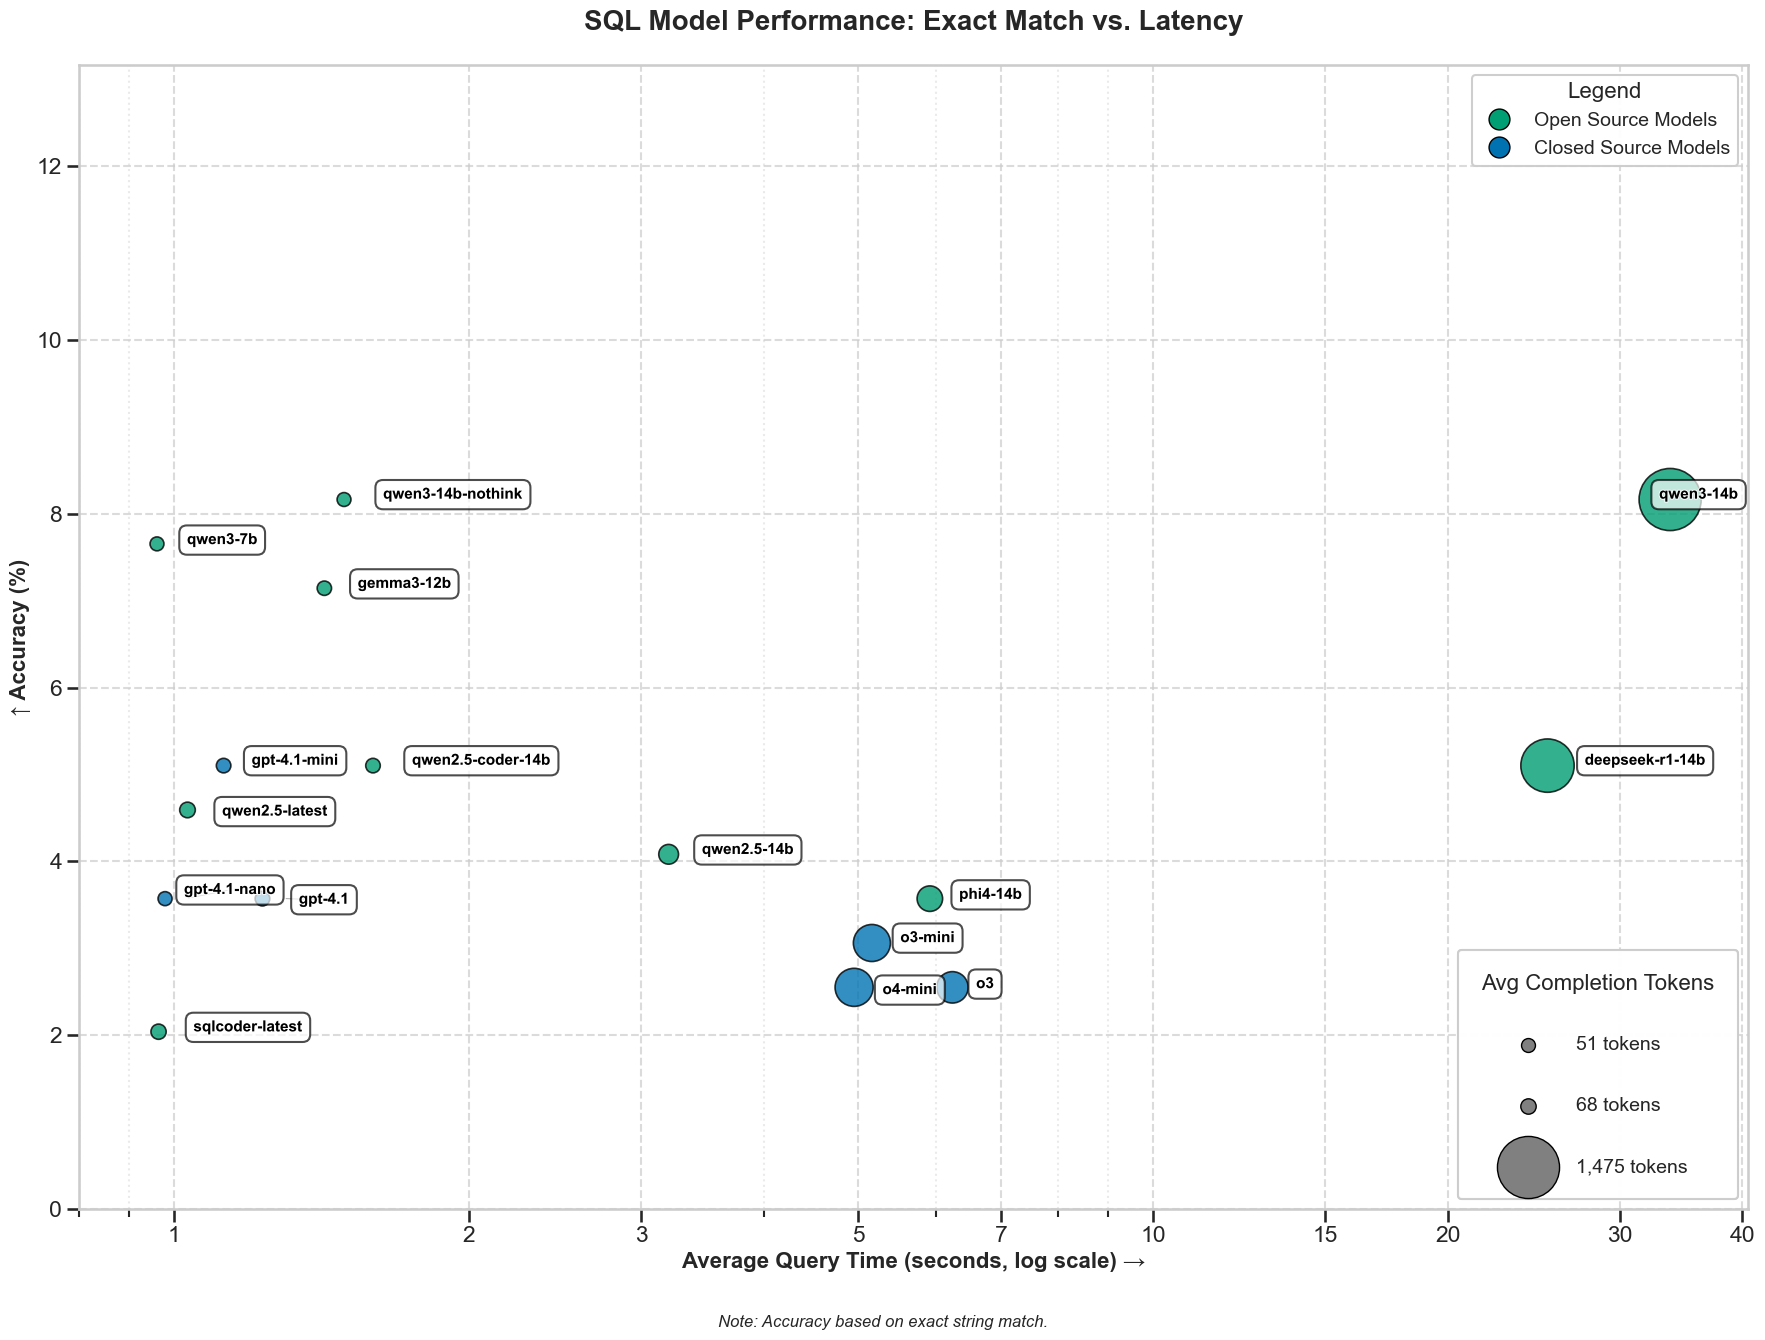

In [81]:
create_model_comparison_chart(metrics, accuracy_metric='exact')

(<Figure size 1800x1400 with 1 Axes>,
 <Axes: title={'center': 'SQL Model Performance: Technical Accuracy vs. Latency'}, xlabel='Average Query Time (seconds, log scale) →', ylabel='↑ Accuracy (%)'>)

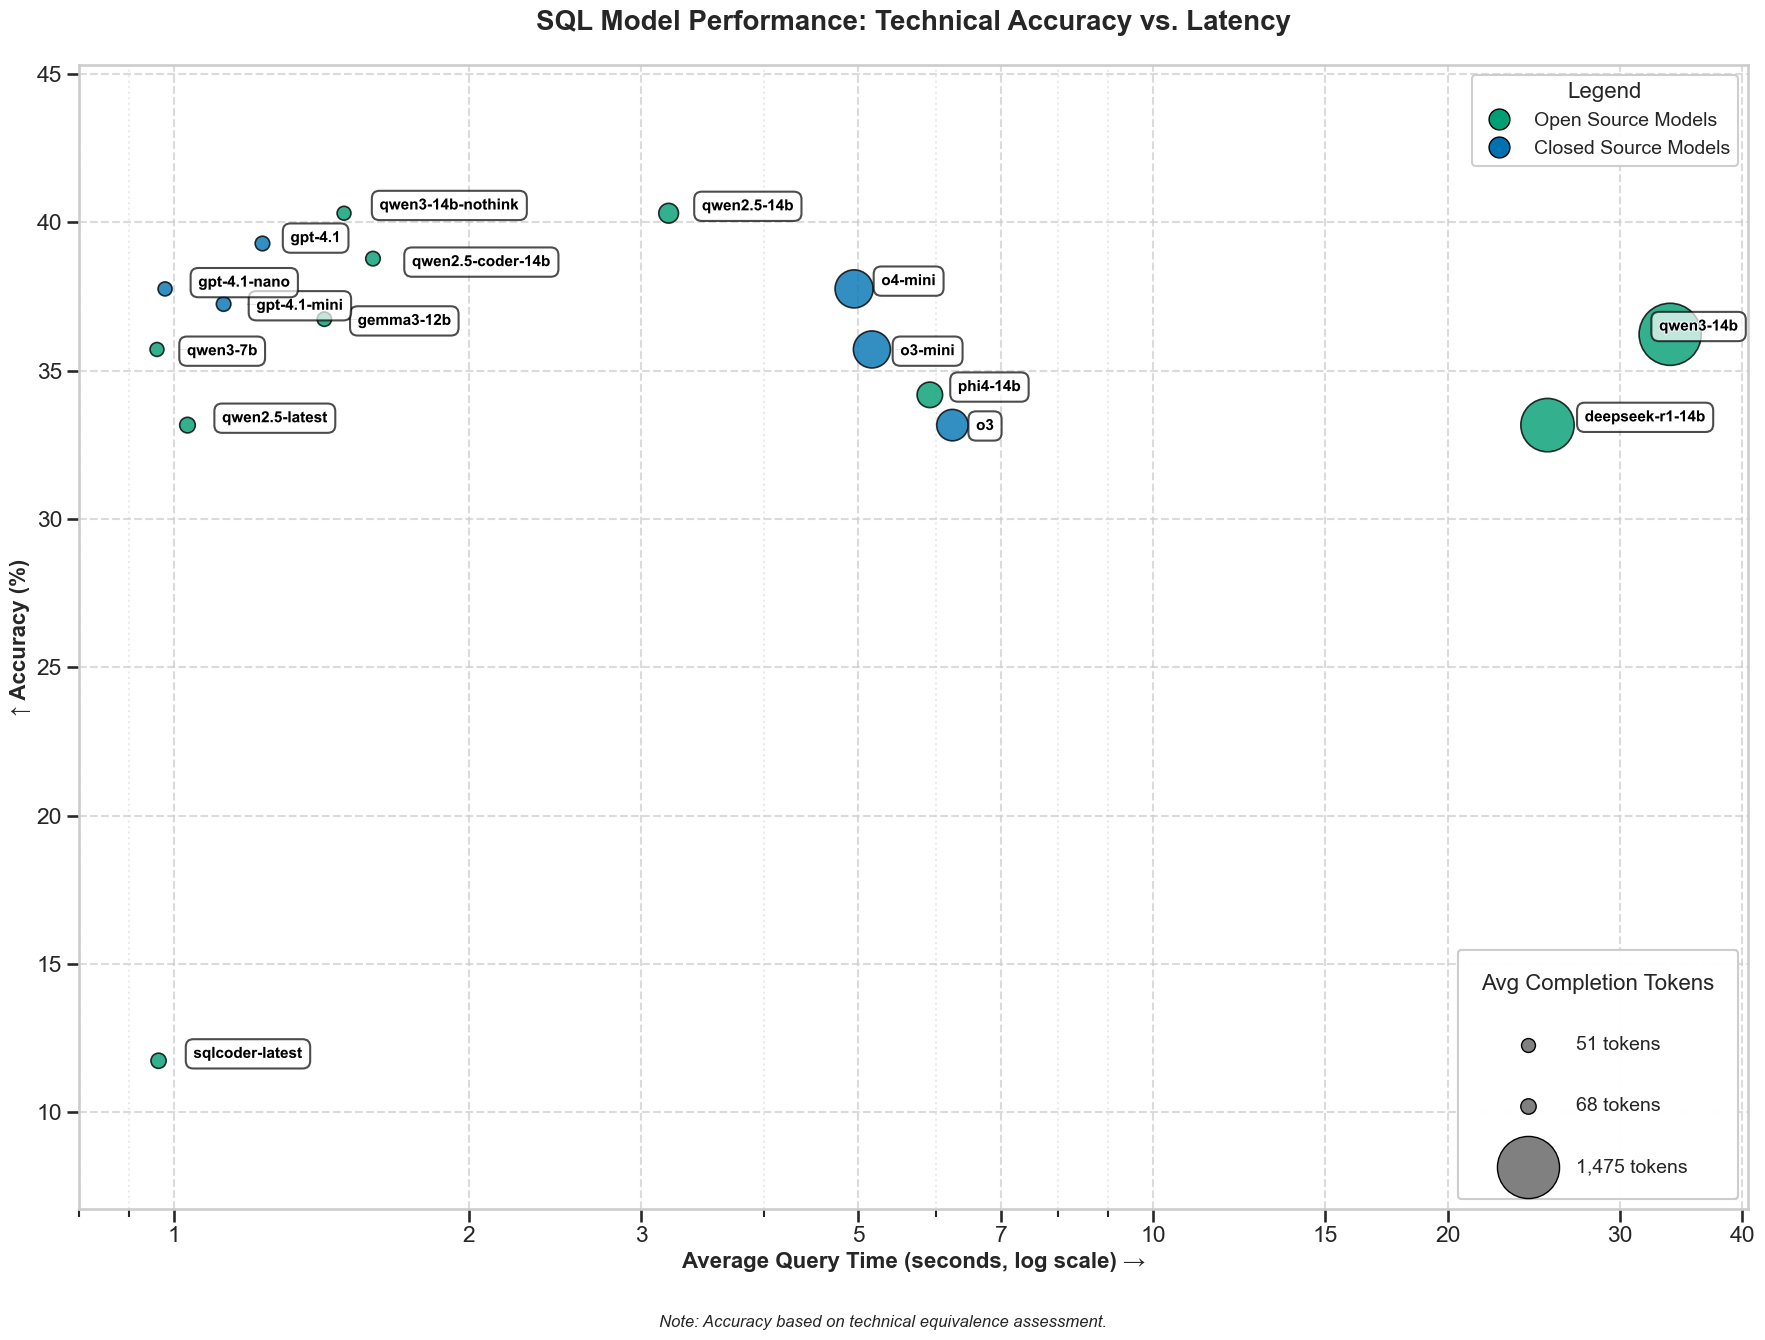

In [82]:
create_model_comparison_chart(metrics, accuracy_metric='technical')

(<Figure size 1800x1400 with 1 Axes>,
 <Axes: title={'center': 'SQL Model Performance: AST Match vs. Latency'}, xlabel='Average Query Time (seconds, log scale) →', ylabel='↑ Accuracy (%)'>)

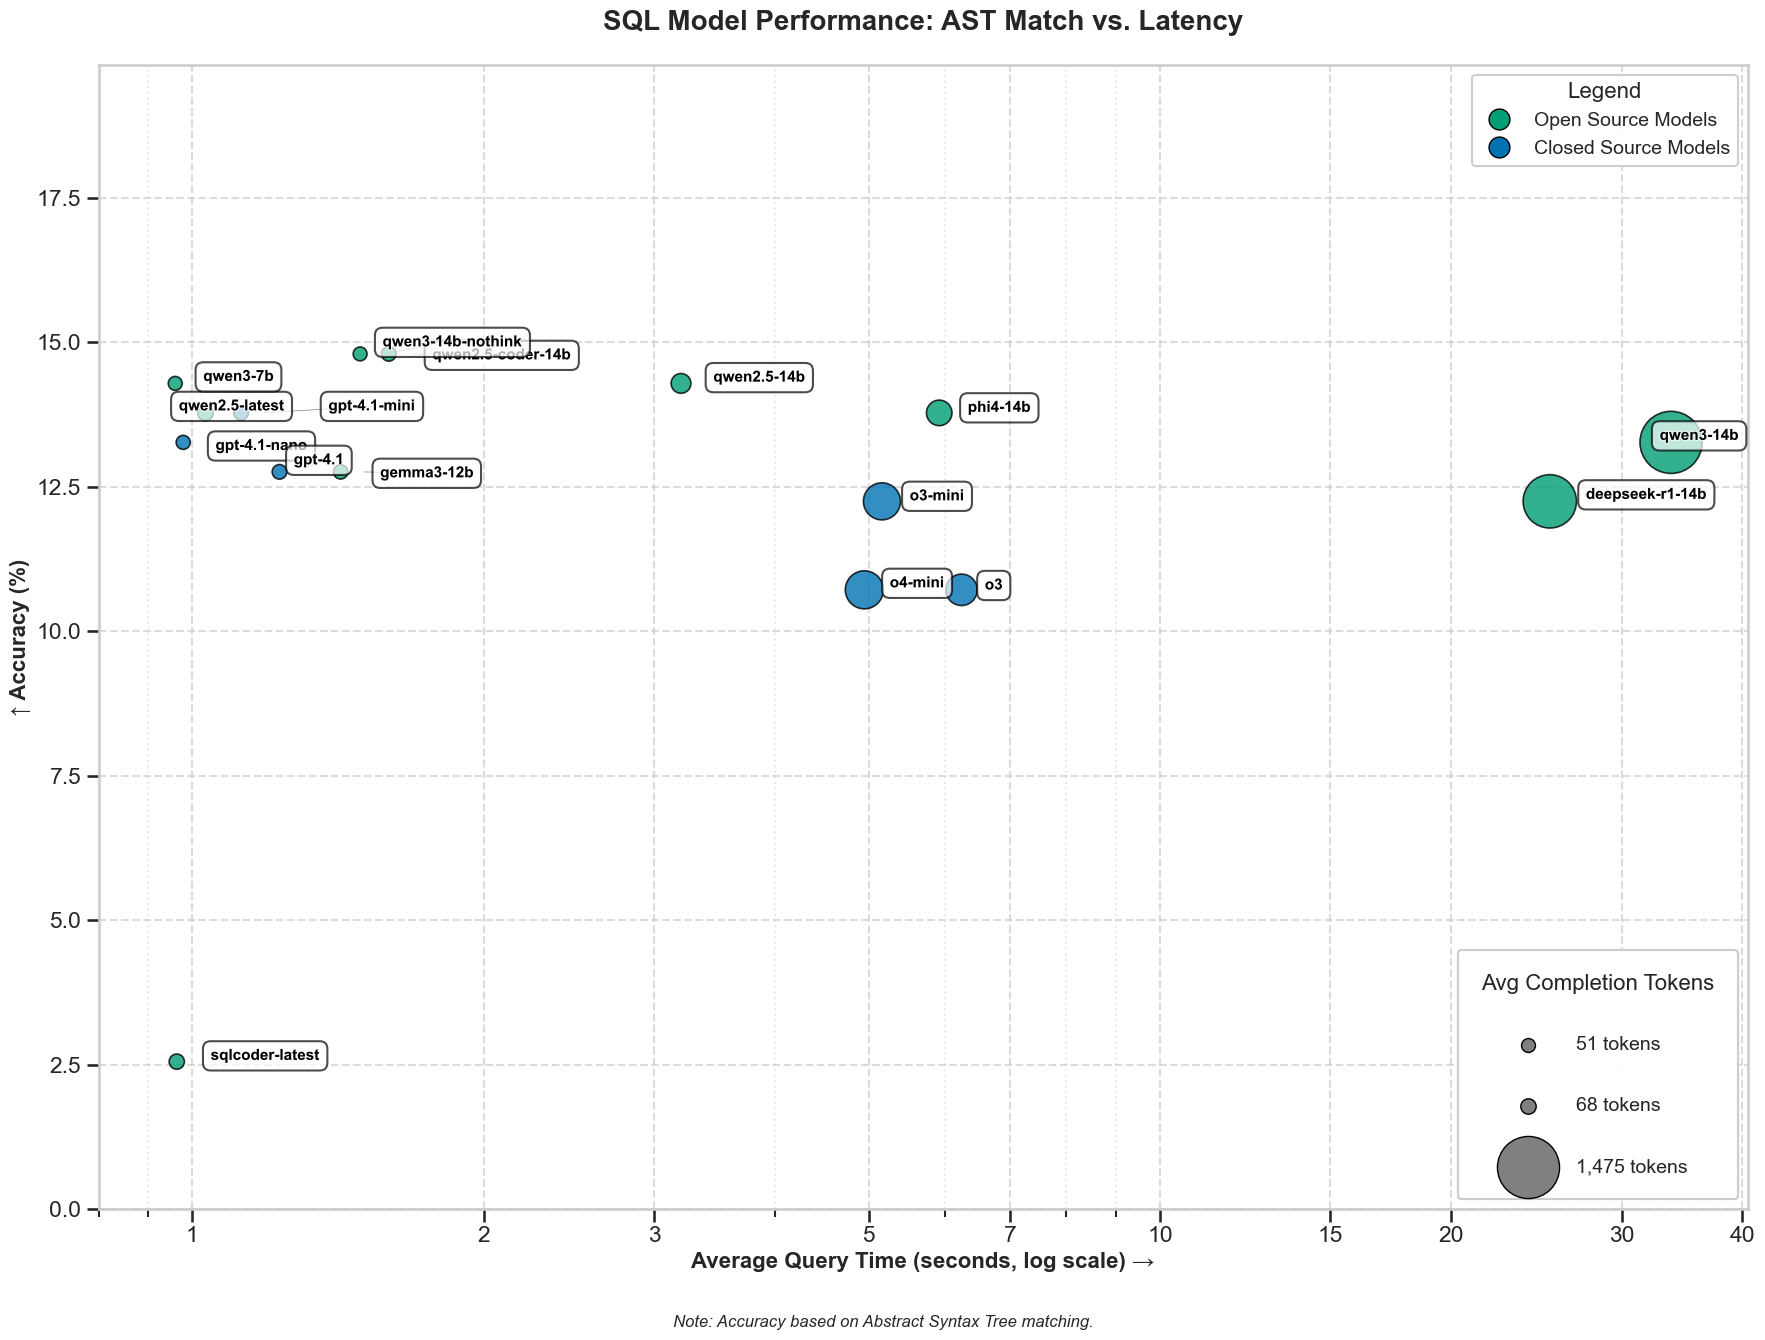

In [83]:
create_model_comparison_chart(metrics, accuracy_metric='ast')

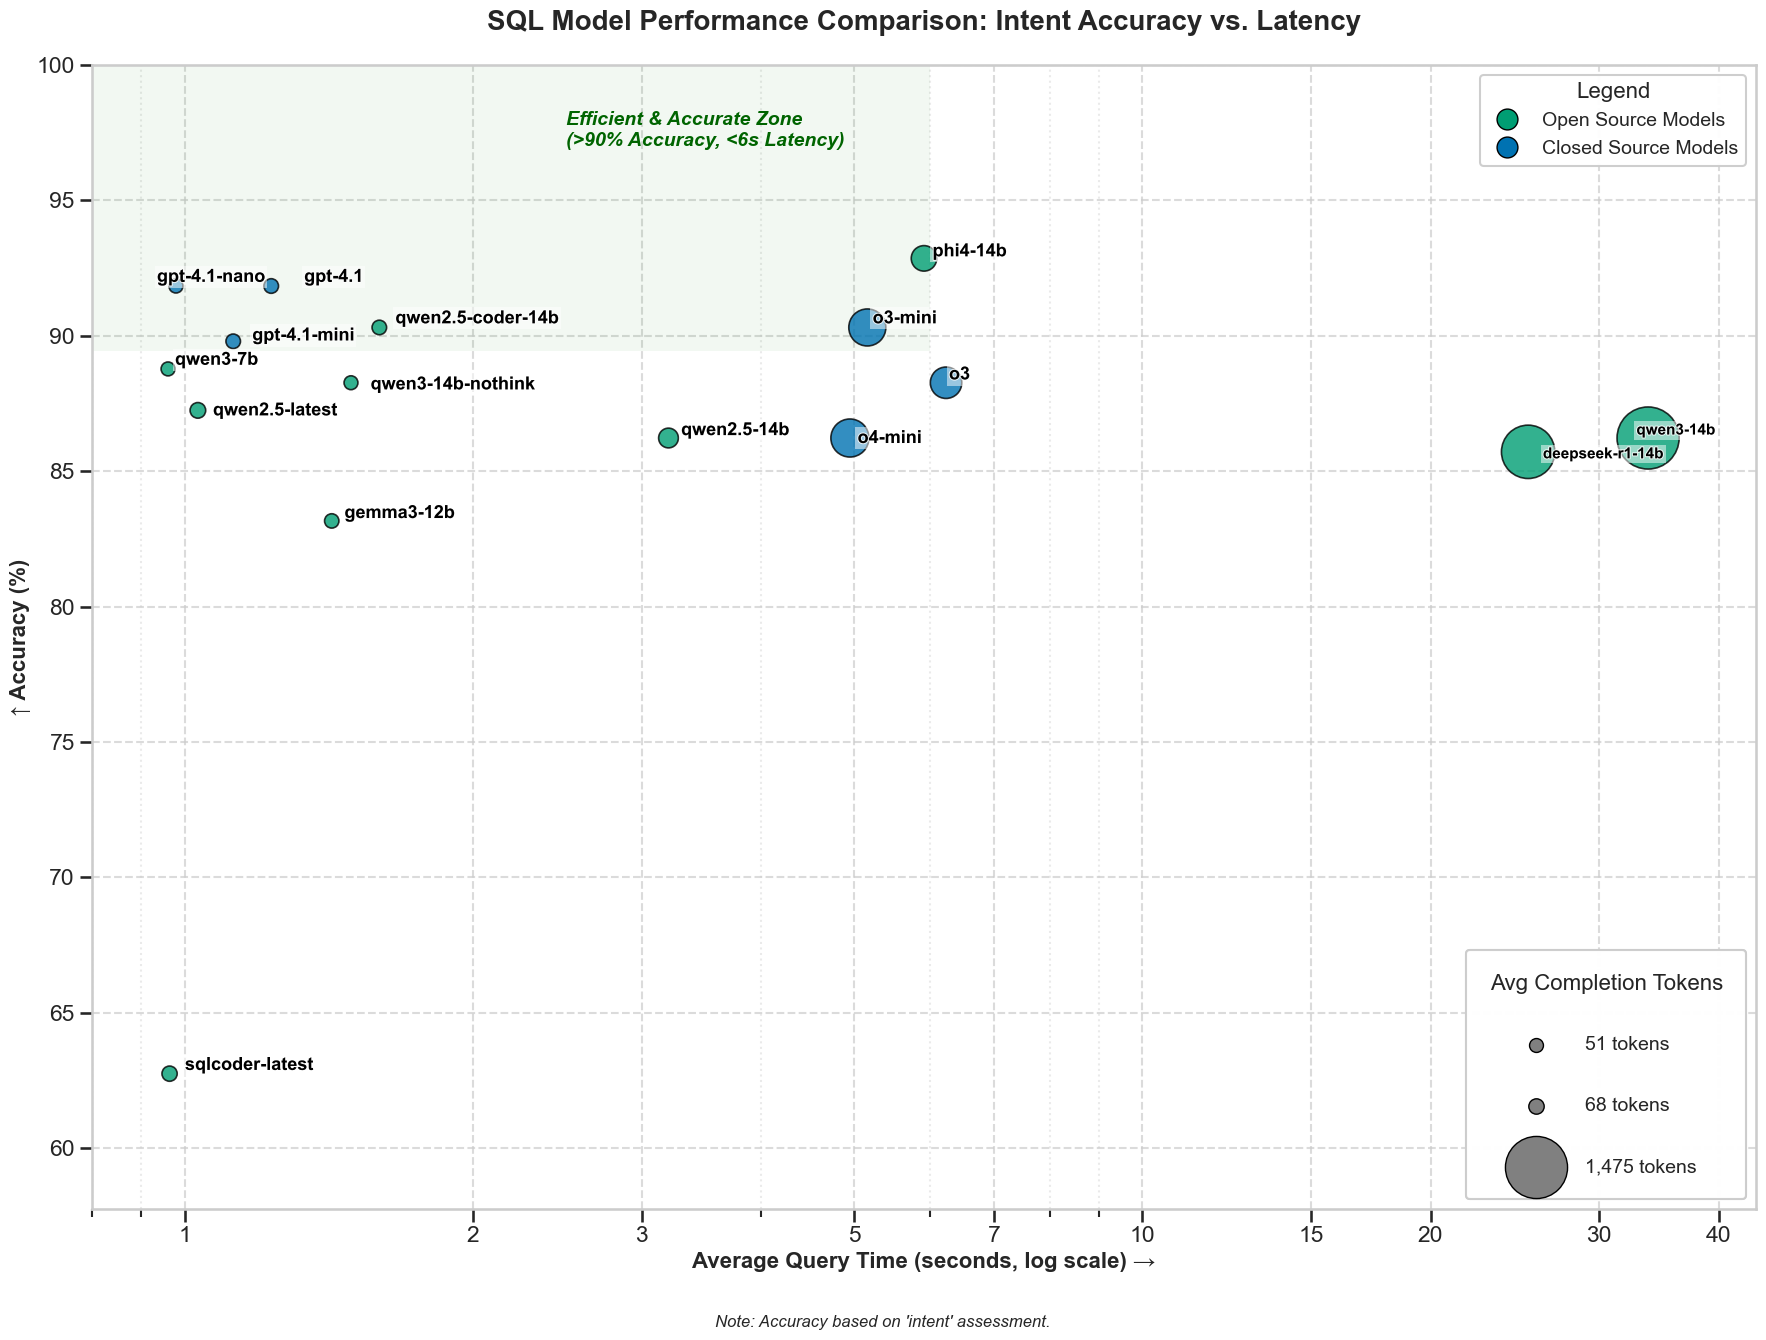

In [84]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib.lines import Line2D
from adjustText import adjust_text

def create_model_comparison_chart(
    metrics_dict, 
    accuracy_metric='intent',  # 'exact', 'ast', 'technical', or 'intent'
    save_path=None
):
    """
    Create a scatter plot comparing models by accuracy, latency, and token usage.
    """
    # Set style for a cleaner look
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("talk")

    # Map accuracy metric to method
    accuracy_method = {
        'exact': 'accuracy_exact',
        'ast': 'accuracy_ast',
        'technical': 'accuracy_judge_technical',
        'intent': 'accuracy_judge_intent'
    }.get(accuracy_metric.lower(), 'accuracy_judge_intent')
    
    # Create DataFrame from metrics
    model_data = []
    for model_key, m in metrics_dict.items():
        accuracy_func = getattr(m, accuracy_method)
        model_data.append({
            'model': m.model_name,
            'accuracy': accuracy_func() * 100,  # Convert to percentage
            'avg_time': m.avg_latency_sec,
            'avg_tokens': m.total_completion_tokens / m.total_queries if m.total_queries > 0 else 0,
            'total_examples': m.total_queries,
            'open_source': m.open_source
        })

    acc_df = pd.DataFrame(model_data)
    
    # Define model categories and colors
    acc_df['category'] = acc_df['open_source'].apply(
        lambda x: 'Open Source Models' if x else 'Closed Source Models')
    category_colors = {
        'Open Source Models': '#009E73',  # Teal green
        'Closed Source Models': '#0072B2'  # Blue
    }
    acc_df['color'] = acc_df['category'].map(category_colors).fillna('#999999')
    
    # Scale token counts for bubble sizes
    S_MIN, S_MAX = 100, 2000
    def scale_sizes(series, s_min=S_MIN, s_max=S_MAX):
        if len(series) <= 1 or series.max() == series.min():
            return np.full_like(series, (s_min + s_max) / 2)
        return np.interp(series, (series.min(), series.max()), (s_min, s_max))
        
    sizes = scale_sizes(acc_df["avg_tokens"])

    # Create plot with log scale
    fig, ax = plt.subplots(figsize=(18, 14))
    ax.set_xscale('log')
    ax.grid(which='major', linestyle='--', alpha=0.7, zorder=0)
    ax.grid(which='minor', linestyle=':', alpha=0.4, zorder=0)
    
    # Add "efficient & accurate" zone
    ax.axvspan(0, 6, ymin=0.75, facecolor='green', alpha=0.05, zorder=1)
    ax.text(2.5, 97, 'Efficient & Accurate Zone\n(>90% Accuracy, <6s Latency)',
            fontsize=14, color='darkgreen', style='italic', weight='bold')
    
    # Create scatter plot
    scatter = ax.scatter(
        acc_df["avg_time"], acc_df["accuracy"], s=sizes, c=acc_df["color"],
        alpha=0.8, edgecolors='black', linewidth=1.2, zorder=10
    )

    # Add model labels with adjustText
    texts = []
    for i, row in acc_df.iterrows():
        text = ax.text(
            row.avg_time, row.accuracy, row.model,
            fontsize=11 if row['avg_time'] > 10 else 13,
            fontweight='bold', zorder=25,
            color='black',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.5, pad=1.5)
        )
        text.set_path_effects([
            path_effects.Stroke(linewidth=1.5, foreground='white', alpha=0.8),
            path_effects.Normal()
        ])
        texts.append(text)

    # Use strong force settings to prevent label overlap
    if len(texts) > 1:
        adjust_text(texts, ax=ax,
                force_text=(10.0, 10.0),
                force_points=(10.0, 10.0),
                expand_text=(5, 5),
                expand_points=(10.5, 10.5),
                lim=1000)

    # Add legend for model categories
    category_handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color, 
                            markeredgecolor='black', markersize=15, label=category) 
                        for category, color in category_colors.items()]
    type_legend = ax.legend(handles=category_handles, loc="upper right", fontsize=14, 
                            frameon=True, framealpha=0.95, title="Legend", title_fontsize=16)
    ax.add_artist(type_legend)

    # Create token size legend
    if len(acc_df) > 1:
        token_vals = [int(acc_df["avg_tokens"].min()), 
                    int(acc_df["avg_tokens"].median()), 
                    int(acc_df["avg_tokens"].max())]
        size_vals = scale_sizes(pd.Series(token_vals))
        handles = [plt.scatter([], [], s=s, color="gray", edgecolor="black", linewidth=1.0) 
                  for s in size_vals]
        labels = [f"{t:,} tokens" for t in token_vals]
        size_legend = ax.legend(handles, labels, title="Avg Completion Tokens", 
                              loc="lower right", fontsize=14, title_fontsize=16, 
                              labelspacing=2.2, borderpad=1.2, handletextpad=1.5, 
                              frameon=True, framealpha=0.95)
        ax.add_artist(size_legend)

    # Set labels and title
    ax.set_xlabel("Average Query Time (seconds, log scale) →", fontsize=16, fontweight='bold')
    ax.set_ylabel("↑ Accuracy (%)", fontsize=16, fontweight='bold')
    ax.set_title(f"SQL Model Performance Comparison: {accuracy_metric.title()} Accuracy vs. Latency", 
                fontsize=20, fontweight='bold', pad=25)

    # Configure axis ticks and limits
    major_ticks = [1, 2, 3, 5, 7, 10, 15, 20, 30, 40]
    ax.xaxis.set_major_locator(mticker.FixedLocator(major_ticks))
    ax.xaxis.set_major_formatter(mticker.ScalarFormatter())
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())

    min_acc = max(55, acc_df["accuracy"].min() - 5) if not acc_df.empty else 55
    max_time = acc_df["avg_time"].max() + 10 if not acc_df.empty else 40
    ax.set_ylim(min_acc, 100)
    ax.set_xlim(left=0.8, right=max_time)

    # Add note and finalize
    plt.figtext(0.5, 0.01, f"Note: Accuracy based on '{accuracy_metric}' assessment.", 
                ha='center', fontsize=12, style='italic')
    plt.tight_layout(rect=[0, 0.03, 1, 0.97])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    return fig, ax

# Usage example:
# Create visualizations with different accuracy metrics
create_model_comparison_chart(metrics, accuracy_metric='intent', save_path='sql_model_comparison_intent.png')
plt.show()

# Optional: Create additional visualizations with different metrics
# create_model_comparison_chart(metrics, accuracy_metric='exact', save_path='sql_model_comparison_exact.png')
# create_model_comparison_chart(metrics, accuracy_metric='technical', save_path='sql_model_comparison_technical.png')